Load Data

In [ ]:
!wget --no-check-certificate \
    https://github.com/btphan95/simple-cnn/blob/master/train.zip?raw=true \
    -O /tmp/train.zip

In [ ]:
!wget --no-check-certificate \
    https://github.com/btphan95/simple-cnn/blob/master/valid.zip?raw=true \
    -O /tmp/valid.zip

In [ ]:
import os 
import zipfile

local_zip = '/tmp/train.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')

local_zip = '/tmp/valid.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
train_dandelion_dir = os.path.join('/tmp/train/dandelion')

train_grass_dir = os.path.join('/tmp/train/grass')

valid_dandelion_dir = os.path.join('/tmp/valid/dandelion')

valid_grass_dir = os.path.join('/tmp/valid/grass')

In [ ]:
train_dandelion_names = os.listdir(train_dandelion_dir)
print(train_dandelion_names[:10])

train_grass_names = os.listdir(train_grass_dir)
print(train_grass_names[:10])

valid_dandelion_names = os.listdir(valid_dandelion_dir)
print(valid_dandelion_names[:10])

valid_grass_names = os.listdir(valid_grass_dir)
print(valid_grass_names[:10])

['00000010.jpg', '00000084.jpg', '00000370.jpg', '00000494.jpg', '00000301.jpg', '00000152.jpg', '00000048.jpg', '00000313.jpg', '00000432.jpg', '00000166.jpg']
['00000010.jpg', '00000084.jpg', '00000370.jpg', '00000494.jpg', '00000301.jpg', '00000152.jpg', '00000048.jpg', '00000313.jpg', '00000432.jpg', '00000166.jpg']
['00000010.jpg', '00000084.jpg', '00000048.jpg', '00000027.jpg', '00000071.jpg', '00000088.jpg', '00000085.jpg', '00000075.jpg', '00000037.jpg', '00000053.jpg']
['00000010.jpg', '00000048.jpg', '00000027.jpg', '00000037.jpg', '00000053.jpg', '00000061.jpg', '00000064.jpg', '00000019.jpg', '00000042.jpg', '00000001.jpg']


In [ ]:
print('total dandelion training images : ', len(os.listdir(train_dandelion_dir)))
print('total grass training images : ', len(os.listdir(train_grass_dir)))
print('total dandelion validation images : ', len(os.listdir(valid_dandelion_dir)))
print('total grass validation images : ', len(os.listdir(valid_grass_dir)))

total dandelion training images :  500
total grass training images :  499
total dandelion validation images :  92
total grass validation images :  65


CNN


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

pic_index = 0

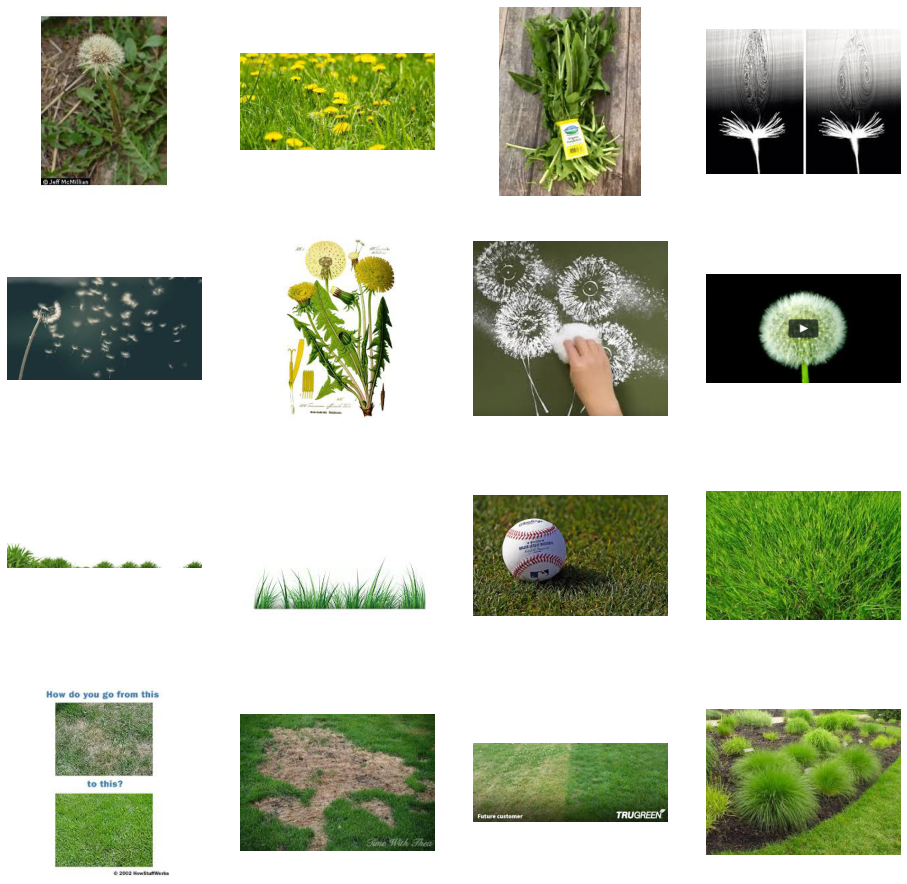

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8

next_dandelion_pic = [os.path.join(train_dandelion_dir, fname)
                      for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir,fname)
                  for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
  sp = plt.subplot(nrows,ncols,i+1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    '/tmp/train/',
    classes = ['dandelion','grass'],
    target_size=(200,200),
    batch_size = 120,
    class_mode='binary'
)
valid_generator = validation_datagen.flow_from_directory(
    '/tmp/valid/',
    classes = ['dandelion','grass'],
    target_size=(200,200),
    batch_size=19,
    class_mode='binary',
    shuffle=False
)

Found 999 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


Build Model

In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm,datasets
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (5, 5), strides=(2,2),
                                                            activation='relu',padding='same',
                                                            input_shape = (200,200,3),
                                                            kernel_initializer='he_normal',
                                                            bias_initializer='zeros'),
                                    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), strides=(2,2),
                                                            activation='relu',padding='same',
                                                            input_shape = (200,200,3),
                                                            kernel_initializer='he_normal',
                                                            bias_initializer='zeros'),
                                    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                                    #tf.keras.layers.Conv2D(64, (3, 3), strides=(2,2),
                                    #                        activation='relu',padding='same',
                                    #                        input_shape = (200,200,3),
                                    #                        kernel_initializer='he_normal',
                                    #                        bias_initializer='zeros'),
                                    #tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128,activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128,activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1,activation=tf.nn.sigmoid),])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 9216)              0         
                                                                 
 dense_30 (Dense)            (None, 128)              

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Training

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=8,
                    epochs=15,
                    verbose=1,
                    validation_data=valid_generator,
                    validation_steps=8)

Epoch 1/15
8/8 [==============================] - 11s 1s/step - loss: 0.0410 - accuracy: 0.9909 - val_loss: 0.8435 - val_accuracy: 0.7697
Epoch 2/15
8/8 [==============================] - 11s 1s/step - loss: 0.0338 - accuracy: 0.9954 - val_loss: 0.8441 - val_accuracy: 0.7697
Epoch 3/15
8/8 [==============================] - 11s 1s/step - loss: 0.0213 - accuracy: 0.9977 - val_loss: 0.8939 - val_accuracy: 0.7566
Epoch 4/15
8/8 [==============================] - 11s 1s/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.9666 - val_accuracy: 0.7566
Epoch 5/15
8/8 [==============================] - 11s 1s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.0406 - val_accuracy: 0.7566
Epoch 6/15
8/8 [==============================] - 11s 1s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.0675 - val_accuracy: 0.7632
Epoch 7/15
8/8 [==============================] - 11s 1s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.0805 - val_accuracy: 0.7500
Epoch 8/15
8/8 [==================

Evaluation Accuracy,ROC,AUC

In [ ]:
model.evaluate(valid_generator)

9/9 [==============================] - 1s 82ms/step - loss: 1.3246 - accuracy: 0.7325


[1.3246132135391235, 0.7324841022491455]

In [ ]:
STEP_SIZE_TEST=valid_generator.n//valid_generator.batch_size
valid_generator.reset()
preds = model.predict(valid_generator,verbose=1)

9/9 [==============================] - 1s 88ms/step


In [ ]:
fpr,tpr,_=roc_curve(valid_generator.classes,preds)

In [ ]:
roc_auc=auc(fpr,tpr)

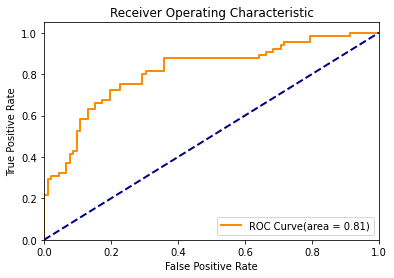

In [ ]:
plt.figure()
lw=2
plt.plot(fpr,tpr,color='darkorange',
         lw=lw,label='ROC Curve(area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('model_2.h5')

Making Predictions

Saving Grass-JW.jpg to Grass-JW.jpg
[1.]
Grass-JW.jpgGrass


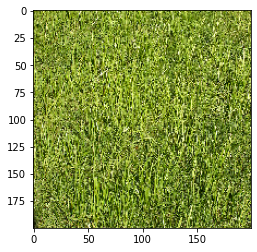

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

upload = files.upload()

for fn in upload.keys():

  path = '/content/'+fn
  img = image.load_img(path,target_size=(200,200))
  x=image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x,axis=0)
  images = np.vstack([x])
  classes = model.predict(images,batch_size =10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn+"Dandelion")
  else:
    print(fn+"Grass")

In [ ]:
import os,signal
os.kill(os.getpid(), signal.SIGKILL)